In [125]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import os
from torchvision.models import vgg19
from torchvision.utils import make_grid

In [126]:
class GeneratorResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.PReLU(),
            
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels), # same as first part but no activation function
        )
        
    def forward(self, x):
        return self.block(x) + x # skip connection from input to output

In [127]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor):
        super().__init__()
        
        self.block = nn.Sequential(
            # generate n^2 channels before collapsing to form n*width, n*height, in_channels image
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels * scale_factor ** 2, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(upscale_factor=scale_factor),
            nn.PReLU()
        )
        
    def forward(self, x):
        return self.block(x)

In [128]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, residual_blocks=16, up_sample_blocks=2, num_features=64):
        super().__init__()
        
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=num_features, kernel_size=9, stride=1, padding=4),
            nn.PReLU()
        )
        
        self.residuals = nn.Sequential(
            *[GeneratorResidualBlock(in_channels=num_features) for _ in range(residual_blocks)]
        )
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=num_features, out_channels=num_features, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features)
        )
        
        self.upsamples = nn.Sequential(
            *[UpsampleBlock(in_channels=num_features, scale_factor=2) for _ in range(up_sample_blocks)]
        )
        
        self.final = nn.Conv2d(in_channels=num_features, out_channels=in_channels, kernel_size=9, stride=1, padding=4)
        
    def forward(self, x):
        x = self.initial(x)
        residual = x
        x = self.residuals(x)
        x = self.conv_block(x)
        x = x + residual
        x = self.upsamples(x)
        x = self.final(x)
        x = torch.tanh(x)
        return x

In [129]:
def test_generator():
    x = torch.randn((5, 3, 64, 64))
    model = Generator()
    generated = model(x)
    print(generated.shape)
    
test_generator()

# passed #

torch.Size([5, 3, 256, 256])


In [130]:
class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(out_channels),
        )
        
    def forward(self, x):
        return self.block(x)

In [131]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
        )
        
        self.blocks = nn.Sequential(
            DiscriminatorBlock(in_channels=64, out_channels=64, stride=2),
            DiscriminatorBlock(in_channels=64, out_channels=128, stride=1),
            DiscriminatorBlock(in_channels=128, out_channels=128, stride=2),
            DiscriminatorBlock(in_channels=128, out_channels=256, stride=1),
            DiscriminatorBlock(in_channels=256, out_channels=256, stride=2),
            DiscriminatorBlock(in_channels=256, out_channels=512, stride=1),
            DiscriminatorBlock(in_channels=512, out_channels=512, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6,6)),
            nn.Flatten(),
            nn.Linear(512*6*6, 1024),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(1024, 1),
        )
        
    def forward(self, x):
        x = self.initial(x)
        x = self.blocks(x)
        x = self.classifier(x)
        
        return x

In [132]:
def test_discriminator():
    x = torch.randn((5, 3, 256, 256))
    model = Discriminator(in_channels=3)
    prediction = model(x)
    print(prediction.shape)
    
test_discriminator()
# passed #

torch.Size([5, 1])


In [133]:
# ----- Hyperparameters ----- #
BATCH_SIZE = 1
EPOCHS = 10
ORIGINAL_IMAGE_SIZE = 256
SCALED_IMAGE_SIZE = 64
LR = 3e-4
LOAD = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [134]:
class VGG19(nn.Module): # used so output of generator can be compared to original image
    def __init__(self):
        super().__init__()
        
        self.vgg = vgg19(pretrained=True).features[:36].eval().to(device)
        self.loss = nn.MSELoss()
        
        for param in self.vgg.parameters():
            param.requires_grad = False
            
    def forward(self, input, target): #input is generated image, target is original image
        vgg_input = self.vgg(input)
        vgg_target = self.vgg(target)
        return self.loss(vgg_input, vgg_target)

In [135]:
transform_original = transforms.Compose([
    transforms.Resize((ORIGINAL_IMAGE_SIZE, ORIGINAL_IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range(3)], [0.5 for _ in range(3)])
])

transform_scaled = transforms.Compose([
    transforms.Resize((SCALED_IMAGE_SIZE, SCALED_IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range(3)], [1 for _ in range(3)])
])

In [136]:
class CelebA(Dataset):
    def __init__(self, root):
        self.root = root
        self.files = os.listdir(root)
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, self.files[idx]))
        
        original_image = transform_original(img)
        scaled_image = transform_scaled(img)
        
        return scaled_image, original_image # input, target

In [137]:
images = CelebA('../celeb_dataset/images')
loader = DataLoader(images, batch_size=BATCH_SIZE, shuffle = True)
fixed_images = next(iter(loader))
fixed_low_res = transforms.Resize((SCALED_IMAGE_SIZE, SCALED_IMAGE_SIZE))(fixed_images[0])
fixed_high_res = fixed_images[1][:5].to(device)

c:\Users\meep2\anaconda3\envs\LLM\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


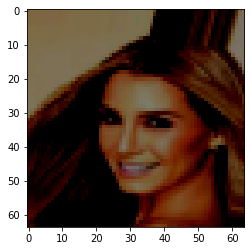

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


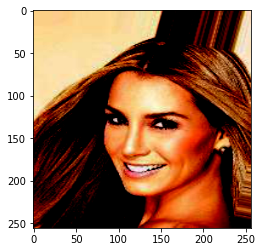

In [138]:
# ----- Loader Test ----- #

plt.imshow(images[0][0].permute(1, 2, 0))
plt.show()
plt.imshow(images[0][1].permute(1, 2, 0))
plt.show()

In [139]:
generator = Generator(in_channels=3, residual_blocks=16, up_sample_blocks=2, num_features=64).to(device)
discriminator = Discriminator(in_channels=3).to(device)

vgg = VGG19().to(device)
BCE = nn.BCEWithLogitsLoss()

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))

c:\Users\meep2\anaconda3\envs\LLM\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\meep2\anaconda3\envs\LLM\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [140]:
def train_generator_batch(low_res, high_res):
    generator.train()
    
    fake_high_res = generator(low_res)
    discriminator_on_fake_high_rez = discriminator(fake_high_res)
    
    adversarial_loss = BCE(discriminator_on_fake_high_rez, torch.ones_like(discriminator_on_fake_high_rez))
    vgg_loss = vgg(fake_high_res, high_res)
    
    loss = 1e-3 * adversarial_loss + 0.006 * vgg_loss # weighted sums as described in the paper
    
    generator_optimizer.zero_grad()
    loss.backward()
    generator_optimizer.step()

In [141]:
def train_discriminator_batch(low_res, high_res):
    discriminator.train()
    
    fake_high_res = generator(low_res)
    
    discriminator_on_real_high_rez = discriminator(high_res)
    discriminator_on_fake_high_rez = discriminator(fake_high_res.detach()) # detatch so gradients dont flow to generator
    
    loss_on_real = BCE(discriminator_on_real_high_rez, torch.ones_like(discriminator_on_real_high_rez))
    loss_on_fake = BCE(discriminator_on_fake_high_rez, torch.zeros_like(discriminator_on_fake_high_rez))
    
    loss = loss_on_real + loss_on_fake
    
    discriminator_optimizer.zero_grad()
    loss.backward()
    discriminator_optimizer.step()

In [142]:
def load_checkpoint(model, optimizer, checkpoint_file):
    print('loading checkpoint...')
    model_dict = model.state_dict()
    checkpoint = torch.load(checkpoint_file, map_location=device)
    
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = LR # reset the learning rate

In [143]:
if LOAD:
    load_checkpoint(generator, generator_optimizer, 'generator.pth.tar')
    load_checkpoint(discriminator, discriminator_optimizer, 'discriminator.pth.tar')

loading checkpoint...


loading checkpoint...


In [144]:
for epoch in range(EPOCHS):
    break
    loop = tqdm(enumerate(loader), leave=False, total=len(loader))
    for batch_idx, (low_res, high_res) in loop:
        low_res = low_res.to(device)
        high_res = high_res.to(device)
        
        train_generator_batch(low_res, high_res)
        train_discriminator_batch(low_res, high_res)
        
        loop.set_description(f"Epoch [{epoch}/{EPOCHS}]")
        
    # ----- Display Test ----- #
    generator.eval()
    fake_high_res = generator(fixed_low_res)
    
    grid = torch.cat((transforms.Resize((ORIGINAL_IMAGE_SIZE, ORIGINAL_IMAGE_SIZE))(fixed_low_res), fake_high_res, fixed_high_res), dim=0)
    grid = make_grid(grid, nrow=5, normalize=True).cpu().detach()
    plt.imshow(grid.permute(1, 2, 0).numpy())
    _ = plt.yticks([])
    _ = plt.xticks([100, 400, 650], ['Low Res', 'Generated', 'High Res'])

In [145]:
generator.eval()
fake_high_res = generator(fixed_low_res.to(device))

grid = torch.cat((transforms.Resize((ORIGINAL_IMAGE_SIZE, ORIGINAL_IMAGE_SIZE))(fixed_low_res).to(device), fake_high_res, fixed_high_res), dim=0).cpu().detach()
grid = make_grid(grid, nrow=5, normalize=True).cpu().detach()

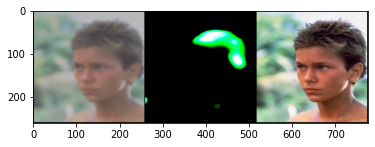

In [146]:
plt.imshow(grid.permute(1, 2, 0))

In [149]:
print(fake_high_res)

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]], device='cuda:0',
       grad_fn=<TanhBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


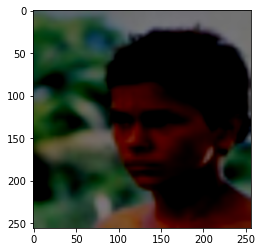

In [148]:
plt.imshow(transforms.Resize((ORIGINAL_IMAGE_SIZE, ORIGINAL_IMAGE_SIZE))(fixed_low_res)[0].permute(1, 2, 0))